# Machine Learning and Content Analytics

 **Hand Gesture Recognition Project** 
* Zachogeorgos Zisimos
* Logari Zoi
* Stavrou Androniki
* Sofroniou Dimitra

**Import the necessary libraries**

In [1]:
# Here we import everything we need for the project

%matplotlib inline
# from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import timeit
import copy
import seaborn as sns


# Sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix, classification_report # Helps present results as a confusion-matrix
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc


# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

print(tf.__version__)


2.6.0


**Fetch Data from Kaggle to Drive**

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=5f35d31faa3a3e21c2611d5d7fda37dd1bf7b637681facbb2fca7fcdb718fbbf
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [4]:
!pwd

/content


In [ ]:
# !mkdir "gdrive/My Drive/Kaggle" # make the directory if not already existing

In [5]:
# changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d gti-upm/leapgestrecog

100% 2.12G/2.13G [00:25<00:00, 85.2MB/s]
100% 2.13G/2.13G [00:25<00:00, 89.3MB/s]


In [ ]:
!pwd
!ls

In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGe

In [8]:
# print the working directory
!pwd 

/content/gdrive/My Drive/Kaggle


In [9]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/leapGestRecog

/content/gdrive/My Drive/Kaggle/leapGestRecog


In [10]:
!pwd

/content/gdrive/My Drive/Kaggle/leapGestRecog


In [11]:
def paths_to_images(root_path):
    # We need to get all the paths for the images to later load them
    imagepaths = []

    # Go through all the files and subdirectories inside a folder and save path to images inside list
    for root, dirs, files in os.walk(root_path, topdown=False): 
      for name in files:
        path = os.path.join(root, name)
        if path.endswith("png"): # We want only the images
          imagepaths.append(path)

    print(len(imagepaths)) # If > 0, then a PNG image was loaded
    return imagepaths

In [12]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

**Data Preprocessing**

In [14]:
def load_images(imagepaths):
    X = [] # Image data
    y = [] # Labels

    # Loops through imagepaths to load images and labels into arrays
    for i, path in enumerate(imagepaths):
        img = cv2.imread(path) # Reads image and returns np.array
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the correct colorspace (GRAY)
        norm_img = np.zeros((800, 800)) # numpy function zeros, which gives a new array of 800*800
        final_img = cv2.normalize(img,  norm_img, 0, 255, cv2.NORM_MINMAX) # normalization 
        img_fin = cv2.resize(final_img, (320, 120)) # Reduce image size so training can be faster
        X.append(img_fin)


        # Processing label in image path
        category = path.split("/")[2] 
        label = int(category.split("_")[0][1]) 
        y.append(label)

        if (i % 100) == 0:
            print("loaded %d images" % i) 

    print("Images loaded: ", len(X))
    print("Labels loaded: ", len(y))

    # print(y[0], imagepaths[0]) # Debugging
    return X, y


In [15]:
# image augmentation functions
def rotate(img, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    return cv2.warpAffine(img, M, (w, h))

def flip_hor(img):
    return cv2.flip(img, 0)

def flip_ver(img):
    return cv2.flip(img, 1)

def flip_both(img):
    return cv2.flip(img, -1)

In [16]:
def augment_dataset(X, y):
    X_new = []
    y_new = []
    for i in range(len(X)):
        img = copy.deepcopy(X[i])
        
        # rotate
        angle = int(random.uniform(-180, 180))
        img_rot = rotate(img, angle)
        
        # flip
        img_flip = flip_hor(img)
        
        X_new.append(img)
        X_new.append(img_rot)
        X_new.append(img_flip)
        
        y_new.append(y[i])
        y_new.append(y[i])
        y_new.append(y[i])
    return X_new, y_new
    
def cv2_to_numpy(X, y):
    # Turn X and y into np.array to speed up train_test_split
    X = np.array(X, dtype="uint8")
    X = np.expand_dims(X, -1) # Needed to reshape so CNN knows it's different images
    y = np.array(y)
    return X, y

In [17]:
t = timeit.default_timer()
root_path = "."
imagepaths = paths_to_images(root_path)
tim = timeit.default_timer() - t
print("Time for getting all paths : %.3f" % tim)

20000
Time for getting all paths : 37.455


(240, 640)


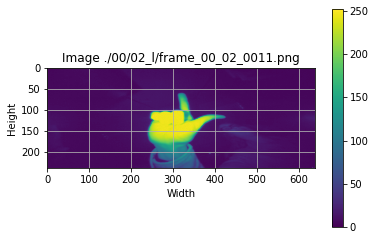

In [18]:
plot_image(imagepaths[222]) #We plot the 222th image from our imagepaths array
plt.colorbar()
plt.grid(True)

# 240 height & 640 width

In [19]:
t = timeit.default_timer()
X, y = load_images(imagepaths)
tim = timeit.default_timer() - t
print("Time for loading images    : %.3f" % tim)

loaded 0 images
loaded 100 images
loaded 200 images
loaded 300 images
loaded 400 images
loaded 500 images
loaded 600 images
loaded 700 images
loaded 800 images
loaded 900 images
loaded 1000 images
loaded 1100 images
loaded 1200 images
loaded 1300 images
loaded 1400 images
loaded 1500 images
loaded 1600 images
loaded 1700 images
loaded 1800 images
loaded 1900 images
loaded 2000 images
loaded 2100 images
loaded 2200 images
loaded 2300 images
loaded 2400 images
loaded 2500 images
loaded 2600 images
loaded 2700 images
loaded 2800 images
loaded 2900 images
loaded 3000 images
loaded 3100 images
loaded 3200 images
loaded 3300 images
loaded 3400 images
loaded 3500 images
loaded 3600 images
loaded 3700 images
loaded 3800 images
loaded 3900 images
loaded 4000 images
loaded 4100 images
loaded 4200 images
loaded 4300 images
loaded 4400 images
loaded 4500 images
loaded 4600 images
loaded 4700 images
loaded 4800 images
loaded 4900 images
loaded 5000 images
loaded 5100 images
loaded 5200 images
loade

In [20]:
t = timeit.default_timer()
X_new, y_new = augment_dataset(X, y)
tim = timeit.default_timer() - t
print("Time for augmenting dataset: %.3f" % tim)

Time for augmenting dataset: 6.910


In [21]:
X, y = cv2_to_numpy(X, y)
X_new, y_new = cv2_to_numpy(X_new, y_new)

In [22]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=25)

# Models

# Model 1

First CNN Model


In [24]:
# Construction of model
model1 = Sequential()
model1.add(Conv2D(16, (3, 3), activation='relu', input_shape=(120, 320, 1))) 
model1.add(MaxPooling2D((16, 16)))
model1.add(Conv2D(8, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(10, activation='softmax'))

# Configures the model for training
model1.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model1.fit(X_train, y_train, epochs=10, batch_size=64, verbose=2, validation_data=(X_test, y_test))
model1.summary()

Epoch 1/10
219/219 - 36s - loss: 3.6267 - accuracy: 0.1316 - val_loss: 2.1972 - val_accuracy: 0.1613
Epoch 2/10
219/219 - 7s - loss: 2.0646 - accuracy: 0.2831 - val_loss: 1.9490 - val_accuracy: 0.3315
Epoch 3/10
219/219 - 7s - loss: 1.7289 - accuracy: 0.4069 - val_loss: 1.4057 - val_accuracy: 0.5140
Epoch 4/10
219/219 - 7s - loss: 1.0554 - accuracy: 0.6470 - val_loss: 0.7482 - val_accuracy: 0.7513
Epoch 5/10
219/219 - 7s - loss: 0.5241 - accuracy: 0.8392 - val_loss: 0.3968 - val_accuracy: 0.8757
Epoch 6/10
219/219 - 7s - loss: 0.2728 - accuracy: 0.9203 - val_loss: 0.2088 - val_accuracy: 0.9442
Epoch 7/10
219/219 - 7s - loss: 0.1740 - accuracy: 0.9516 - val_loss: 0.1468 - val_accuracy: 0.9638
Epoch 8/10
219/219 - 7s - loss: 0.1350 - accuracy: 0.9635 - val_loss: 0.1403 - val_accuracy: 0.9603
Epoch 9/10
219/219 - 7s - loss: 0.1002 - accuracy: 0.9729 - val_loss: 0.0929 - val_accuracy: 0.9785
Epoch 10/10
219/219 - 7s - loss: 0.0828 - accuracy: 0.9785 - val_loss: 0.0988 - val_accuracy: 0.970

# Model 2

Best CNN Model


In [26]:
# Construction of model
model2 = Sequential()
model2.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu')) 
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(10, activation='softmax'))

In [27]:
# Configures the model for training
model2.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
               loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
               metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [30]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
hist = model2.fit(X_train, y_train, epochs=10, batch_size=64, verbose=2, validation_data=(X_test, y_test))
hist

Epoch 1/10
219/219 - 27s - loss: 8.6009e-07 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9995
Epoch 2/10
219/219 - 27s - loss: 7.1724e-07 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9998
Epoch 3/10
219/219 - 27s - loss: 6.0310e-07 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9998
Epoch 4/10
219/219 - 27s - loss: 5.1202e-07 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9998
Epoch 5/10
219/219 - 27s - loss: 4.3610e-07 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9995
Epoch 6/10
219/219 - 27s - loss: 3.7344e-07 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9998
Epoch 7/10
219/219 - 27s - loss: 3.2046e-07 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9998
Epoch 8/10
219/219 - 27s - loss: 2.7692e-07 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9995
Epoch 9/10
219/219 - 27s - loss: 2.4007e-07 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9998
Epoch 10/10
219/219 - 27s - loss: 2.0860e-07 - accuracy

In [31]:
# Save entire model to a HDF5 file
model2.save('finalmodel-CNN.h5')

**Qualitative Analysis of the Model**

In [66]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(10)

In [67]:
val_acc


[0.9994999766349792,
 0.999833345413208,
 0.999833345413208,
 0.999833345413208,
 0.9994999766349792,
 0.999833345413208,
 0.999833345413208,
 0.9994999766349792,
 0.999833345413208,
 0.999833345413208]

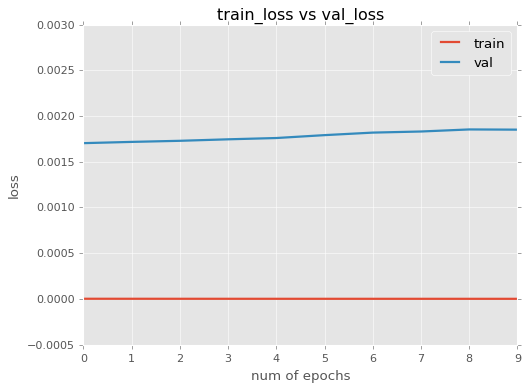

In [83]:
plt.figure(figsize=(7,5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.ylim(-0.0005, 0.003)
plt.legend(['train','val'])
plt.style.use('ggplot')

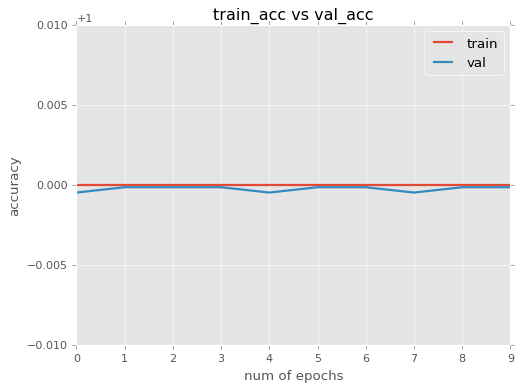

In [88]:
plt.figure(figsize=(7,5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('num of epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.ylim(0.99, 1.01)
plt.legend(['train','val'])

In [34]:
# Recreate the exact same model, including weights and optimizer.
model = keras.models.load_model('finalmodel-CNN.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 116, 316, 32)      832       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 58, 158, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 156, 64)       18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 78, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 76, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 38, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 31616)            

In [35]:
# testing model

test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

188/188 [==============================] - 6s 26ms/step - loss: 0.0019 - accuracy: 0.9998
Test accuracy: 99.98%


In [36]:
predictions = model.predict(X_test) # Make predictions towards the test set

In [37]:
np.argmax(predictions[0]), y_test[0] # index of max element

(3, 3)

In [38]:
# Function to plot images and labels for validation purposes
def validate_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

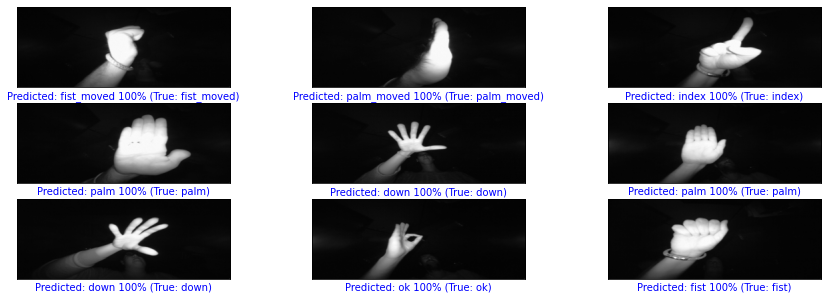

In [39]:
validate_images(predictions, y_test, X_test)

In [40]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [41]:
# H = Horizontal
# V = Vertical

conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])
conf_matrix

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,592,0,0,0,0,0,0,0,0,0
Actual Palm (H),0,606,0,0,0,0,0,0,0,1
Actual L,0,0,596,0,0,0,0,0,0,0
Actual Fist (H),0,0,0,626,0,0,0,0,0,0
Actual Fist (V),0,0,0,0,590,0,0,0,0,0
Actual Thumbs up,0,0,0,0,0,612,0,0,0,0
Actual Index,0,0,0,0,0,0,603,0,0,0
Actual OK,0,0,0,0,0,0,0,601,0,0
Actual Palm (V),0,0,0,0,0,0,0,0,559,0
Actual C,0,0,0,0,0,0,0,0,0,614


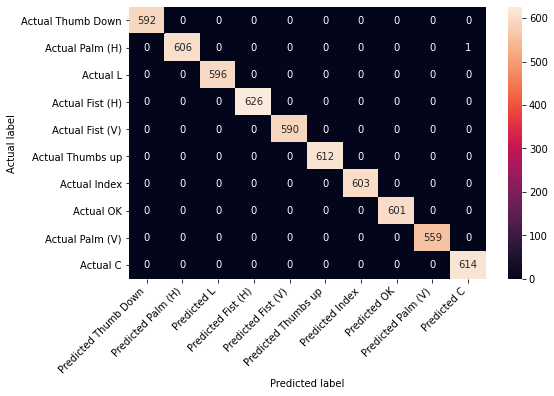

In [42]:
df_cm = pd.DataFrame(conf_matrix)
fig = plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=10)

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=10)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [43]:
# saving weights

fname = "weights_final_cnn_model.h5"
model.save_weights(fname, overwrite= True)